# jsPCA Monoslice Tutorial

This notebook demonstrates how to apply jsPCA to spatial transcriptomics data 
stored in `.h5ad` format.

- Input data: `data/DLPFC/*.h5ad`
- Output results: `results/Monoslice/`
- Evaluation metrics: ARI, NMI, runtime, memory

It includes:
- Loading `.h5ad` files.
- Preprocessing spatial transcriptomics data.
- Computing adjacency matrices using the mutual k-nearest neighbor (KNN) method.
- Performing joint spatial PCA (jsSPCA)
- Clustering with Gaussian Mixture Models (GMM)
- Spatial refinement 
- Evaluating performance (ARI, NMI)
- Saving results
  
This notebook assumes you have a folder `data/DLPFC` with `.h5ad` files and the required utility scripts in `utils/`.

## Imports and setup

In [16]:
# ===============================
# Import Libraries
# ===============================

# -------------------------------
# System libraries
# -------------------------------
import os        # For path manipulations
import sys       # To modify Python path
import glob      # For finding files with patterns
import warnings  # To suppress warning messages


# -------------------------------
# Data handling
# -------------------------------
import numpy as np
import pandas as pd

# -------------------------------
# Single-cell / spatial transcriptomics
# -------------------------------
import anndata as ad       # AnnData format
import scanpy as sc        # Preprocessing, normalization, scaling
import SpaGCN as spg       # For spatial cluster refinement

# -------------------------------
# Visualization
# -------------------------------
import matplotlib.pyplot as plt   # Plotting library for creating static, interactive, and animated visualizations

# -------------------------------
# Sparse matrices
# -------------------------------
from scipy.sparse import csr_matrix

# -------------------------------
# Clustering evaluation metrics
# -------------------------------
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# -------------------------------
# Project-specific utility functions
# -------------------------------

# Navigate to parent directory and add utils/ to path
project_root = os.path.dirname(os.getcwd())
utils_path = os.path.join(project_root, "utils")
sys.path.insert(0, utils_path)
print(f"✅ Utils folder added to path: {utils_path}")


from hungarian_algorithm import apply_hungarian_algorithm
from projection_utils import project_components
from eigen_utils import compute_sorted_eigen
from clustering_utils import perform_gmm_clustering
from adjacency_matrix_knn import compute_mutual_knn_matrices
from spca_utils import compute_spca

# -------------------------------
# Suppress warnings to keep notebook output clean
# -------------------------------
warnings.filterwarnings("ignore")

print("✅ All libraries imported successfully.")

✅ Utils folder added to path: C:\Users\assali.i\Desktop\jspca-project\utils
✅ All libraries imported successfully.


## Define input and output folders

This section defines the input folder containing `.h5ad` files and creates an output folder to store the results.

In [17]:
# ===============================
# Define file paths
# ===============================

# Base directory: folder where the project is located
# For notebook: use os.getcwd(); for script: use os.path.dirname(os.path.abspath(__file__))
try:
    base_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    base_dir = os.getcwd()  # fallback if running in a notebook

# Input folder containing spatial transcriptomics .h5ad files
folder_path = os.path.join(base_dir, "..", "data", "DLPFC")  # ".." goes up one folder to reach the correct path

# Output folder to save results
output_folder = os.path.join(base_dir, "..", "results", "Monoslice")
os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist

# List all .h5ad files in the input folder 
file_list = sorted([f for f in glob.glob(os.path.join(folder_path, "*")) if f.lower().endswith(".h5ad")])

# Display file information
if not file_list:
    print("⚠️ No .h5ad files found in:", folder_path)
else:
    print(f"📂 Found {len(file_list)} files to process:")
    for f in file_list:
        print("  •", os.path.basename(f))

📂 Found 1 files to process:
  • 151673.h5ad


## Iterative preprocessing of `.h5ad` datasets

In this section, we iterate over each file, load it into an AnnData object, filter out lowly expressed genes, normalize the data, scale it, and verify the presence of ground-truth labels.

In [18]:
# ===============================
# Loop over each dataset
# ===============================
for file_path in file_list:

    # Extract file name and sample name (without extension)
    file_to_read = os.path.basename(file_path)
    sample_name = file_to_read.replace(".h5ad", "")
    print(f"\n=== Processing sample: {sample_name} ===")

    # -------------------------------
    # Step 1: Load AnnData object
    # -------------------------------
    adata = ad.read_h5ad(file_path)
    print(f"Original data shape: {adata.shape} (cells x genes)")

    # -------------------------------
    # Step 2: Preprocessing
    # -------------------------------
    # Filter genes expressed in fewer than 20 cells
    sc.pp.filter_genes(adata, min_cells=20)

    # Normalize using Pearson residuals 
    sc.experimental.pp.normalize_pearson_residuals(adata)

    # Scale data to zero mean and unit variance
    sc.pp.scale(adata)

    # -------------------------------
    # Step 3: Check ground-truth labels
    # -------------------------------
    if 'ground_truth' not in adata.obs:
        print(f"⚠️ Skipping {file_to_read}: 'ground_truth' column not found.")
        continue

    # Count number of unique labels for clustering
    num_labels = adata.obs['ground_truth'].nunique()
    print(f"Detected {num_labels} unique ground-truth clusters.")


=== Processing sample: 151673 ===
Original data shape: (3639, 33538) (cells x genes)
Detected 7 unique ground-truth clusters.


## Compute adjacency matrices

In this section, we compute adjacency matrices using the mutual k-nearest neighbor (KNN) method, which defines neighboring spots and captures their local spatial relationships.

In [19]:
# -------------------------------
# Compute adjacency matrices (connectivity matrices)
# -------------------------------
# This computes a distance matrix and a connectivity matrix between spots
print("🔗 Computing adjacency matrices ...")
dist_matrix, connectivity_matrix = compute_mutual_knn_matrices(adata)

# Store matrices in AnnData object
adata.obsp['distances'] = dist_matrix
adata.obsp['connectivities'] = csr_matrix(connectivity_matrix)

🔗 Computing adjacency matrices ...
Automatically selected k = 18
Mutual KNN graph construction successful!


## Computing jsPCA 

In this step, we test different numbers of jsPCA components (eigenvectors) with `k = 10, 20, 30, 40, 50`. Each value of `k` determines how many principal components we use to represent the data. By testing multiple numbers of eigenvectors, we aim to select the optimal number that best captures the underlying structure of the data for clustering.  

For each `k`, we perform the following:

- **Compute jsPCA:** First, compute the spatial covariance matrix, then extract the top k principal components from it to reduce dimensionality while preserving important patterns.  
- **Project components:** Map the original data onto these `k` eigenvectors to create a lower-dimensional representation suitable for clustering.  
- **Perform GMM clustering:** Apply Gaussian Mixture Models to assign each spot to a cluster.  
- **Refine clusters:** Adjust cluster assignments based on spatial neighborhood information to improve biological relevance.  
- **Evaluate clustering quality:** Compare refined clusters to ground truth labels using ARI (Adjusted Rand Index) and NMI (Normalized Mutual Information) to identify the best-performing number of components.  

By iterating over different numbers of eigenvectors, we can choose the value of `k` that yields the most accurate and meaningful clustering.

In [20]:
# -------------------------------
# jsPCA computation
# -------------------------------
# Initialize variables to keep track of the best clustering result
best_score, best_data = -1, None  # best_score will store the highest ARI/NMI score, best_data will store the corresponding AnnData object

# Loop over different numbers of jsSPCA components (eigenvectors) to find the optimal number
for k in [10, 20, 30, 40, 50]:
    print(f"\n🔹 Testing num_eigenvectors = {k}")
    
    try:
        # =========================
        # Step 1: Compute jSPCA
        # =========================
        # Compute the spatial covariance matrix
        A = compute_spca(adata)
        
        # Compute the top k eigenvalues and eigenvectors from the spatial covariance matrix
        eigvals, eigvecs = compute_sorted_eigen(A, k)
        
        # Project the original data onto the top k eigenvectors
        projection_df = project_components(adata.X, np.real(eigvecs), k)
        
        # Skip this k if the projection contains NaNs
        if np.isnan(projection_df.values).any():
            print(f"⚠️ NaNs found in projection. Skipping k={k}")
            continue
        
        # =========================
        # Step 2: Perform GMM clustering
        # =========================
        # Cluster the projected data using Gaussian Mixture Models
        gmm_clusters = perform_gmm_clustering(projection_df, num_labels, random_state=42)
        
        # =========================
        # Step 3: Spatial refinement 
        # =========================
        try:
            # Retrieve spatial coordinates for refinement
            if "x" in adata.obs and "y" in adata.obs:
                x_array, y_array = adata.obs["x"].tolist(), adata.obs["y"].tolist()
            elif "spatial" in adata.obsm:
                x_array, y_array = adata.obsm["spatial"][:, 0].tolist(), adata.obsm["spatial"][:, 1].tolist()
            else:
                raise ValueError("Spatial coordinates missing")
            
            # Compute the adjacency matrix based on spatial relationships
            adj_2d = spg.calculate_adj_matrix(x=x_array, y=y_array, histology=False)
            
            # Refine the GMM clusters using SpaGCN, which incorporates spatial information
            refined_pred = spg.refine(
                sample_id=adata.obs.index.tolist(),  # list of spot/cell IDs
                pred=gmm_clusters,                   # initial GMM cluster assignments
                dis=adj_2d,                          # adjacency matrix of neighbors
                shape="hexagon"                      # spatial layout shape
            )
            
            # Store refined clusters in AnnData object
            adata.obs["refined_pred"] = pd.Categorical(refined_pred)
            
            # Keep only spots with both refined predictions and ground truth
            obs_df = adata.obs.dropna(subset=["refined_pred", "ground_truth"])
            
            # =========================
            # Step 4: Evaluate clustering
            # =========================
            # Compute Adjusted Rand Index (ARI) between refined clusters and ground truth
            ari = adjusted_rand_score(obs_df["refined_pred"], obs_df["ground_truth"])
            
            # Compute Normalized Mutual Information (NMI) between refined clusters and ground truth
            nmi = normalized_mutual_info_score(obs_df["refined_pred"], obs_df["ground_truth"])
            
            # Combine ARI and NMI into a single score for comparison
            score = (ari + nmi) / 2
            
            # Print clustering performance for current k
            print(f"✅ ARI: {ari:.4f}, NMI: {nmi:.4f}, Score: {score:.4f}")
            
        except Exception as refine_error:
            # If spatial refinement fails, skip this k
            print(f"⚠️ Refinement failed for k={k}: {refine_error}")
            continue
        
        # =========================
        # Step 5: Save the best result
        # =========================
        # If the current score is better than the best score so far, update best_score and best_data
        if score > best_score:
            best_score = score                # update the best score
            best_data = adata.copy()          # store a copy of the AnnData object
            best_data.obs['GMM_clusters'] = gmm_clusters
            best_data.obs['refined_pred'] = pd.Categorical(refined_pred)
            best_data.uns.update({
                'ARI': ari,
                'NMI': nmi,
                'best_num_eigenvalues': k  # store which k gave the best result
            })
            
    except Exception as e:
        # If any error occurs in this k iteration, skip to the next one
        print(f"❌ Error for k={k}: {e}")
        continue



🔹 Testing num_eigenvectors = 10
Calculateing adj matrix using xy only...
✅ ARI: 0.6199, NMI: 0.7128, Score: 0.6664

🔹 Testing num_eigenvectors = 20
Calculateing adj matrix using xy only...
✅ ARI: 0.6284, NMI: 0.6924, Score: 0.6604

🔹 Testing num_eigenvectors = 30
Calculateing adj matrix using xy only...
✅ ARI: 0.6077, NMI: 0.6908, Score: 0.6493

🔹 Testing num_eigenvectors = 40
Calculateing adj matrix using xy only...
✅ ARI: 0.5939, NMI: 0.6941, Score: 0.6440

🔹 Testing num_eigenvectors = 50
Calculateing adj matrix using xy only...
✅ ARI: 0.4732, NMI: 0.6213, Score: 0.5472


## Save Results

We save the best result for each sample as an `.h5ad` file and export ARI/NMI scores as Excel files.

In [21]:
if best_data is not None:
    out_file = os.path.join(output_folder, f"jsPCA_{sample_name}_results.h5ad")
    best_data.write(out_file)
    print(f"💾 Results saved to {out_file}")
    
    # Save ARI/NMI scores
    pd.DataFrame({
        'Sample': [sample_name],
        'ARI': [best_data.uns['ARI']],
        'NMI': [best_data.uns['NMI']]
    }).to_excel(os.path.join(output_folder, f"{sample_name}_jspca_ari_nmi.xlsx"), index=False)
    
else:
    print(f"⚠️ No valid result for {sample_name}")

💾 Results saved to C:\Users\assali.i\Desktop\jspca-project\tutorial\..\results\Monoslice\jsPCA_151673_results.h5ad


## Visualization 

In this section, we visualize the final results obtained.
It is divided into two main parts:
 1. Alignment of predicted clusters with ground truth labels using the **Hungarian algorithm**
 2. Visualization of spatial cluster assignments

### Cluster Assignment with the Hungarian Algorithm

After performing joint jsPCA and spatial refinement, the cluster labels may not directly match the ground truth labels. To ensure consistent comparison, we use the Hungarian algorithm to find the optimal one-to-one mapping between predicted clusters and ground truth classes.

This step:
  1. Loads all joint jsPCA output files
  2. Aligns predicted clusters with ground truth using the Hungarian algorithm
  3. Saves aligned results to new `.h5ad` files

In [22]:
# -------------------------------
# Apply Hungarian Algorithm to Match Labels
# -------------------------------

folder_path = output_folder

print("🔍 Folder path:", os.path.abspath(folder_path))

# Collect all jsPCA result files 
file_list = glob.glob(os.path.join(folder_path, "*.h5ad"))

print(f"📁 Found {len(file_list)} .h5ad files:")
for f in file_list:
    print("  •", os.path.basename(f))

# Sort files by numeric ID
def extract_numeric_id(path):
    filename = os.path.basename(path)
    digits = ''.join(filter(str.isdigit, filename))
    return int(digits) if digits else 0

file_list = sorted(file_list, key=extract_numeric_id)

# Ground truth key (adjust if needed)
gt_key = 'Region'

for file_path in file_list:
    file_name = os.path.basename(file_path)
    print(f"\n🔹 Processing file: {file_name}")

    adata = ad.read_h5ad(file_path)
    print("Available columns in .obs:", list(adata.obs.columns))

    if gt_key not in adata.obs or 'refined_pred' not in adata.obs:
        print(f"⚠️ Skipping {file_name}: Missing '{gt_key}' or 'refined_pred'.")
        continue

    refined_labels = adata.obs['refined_pred']
    valid_idx = ~adata.obs[gt_key].isna() & ~refined_labels.isna()
    print(f"✅ Valid spots for matching: {valid_idx.sum()} / {len(valid_idx)}")

    if valid_idx.sum() == 0:
        print(f"⚠️ No valid labels to match in {file_name}.")
        continue

    valid_gt = adata.obs[gt_key][valid_idx]
    valid_refined = refined_labels[valid_idx]

    try:
        mapped_labels = apply_hungarian_algorithm(valid_gt, valid_refined)

        full_mapped = np.full(len(adata), np.nan, dtype=object)
        full_mapped[valid_idx] = mapped_labels

        adata.obs['refined_pred_Hungarian'] = pd.Categorical(
            full_mapped,
            categories=adata.obs[gt_key].cat.categories
        )

        # Save the updated matched file in the same output folder
        output_path = os.path.join(folder_path, file_name.replace(".h5ad", "_matched.h5ad"))
        adata.write(output_path)
        print(f"✅ Saved updated file: {output_path}")

    except Exception as e:
        print(f"❌ Error processing {file_name}: {e}")

🔍 Folder path: C:\Users\assali.i\Desktop\jspca-project\results\Monoslice
📁 Found 1 .h5ad files:
  • jsPCA_151673_results.h5ad

🔹 Processing file: jsPCA_151673_results.h5ad
Available columns in .obs: ['in_tissue', 'array_row', 'array_col', 'Region', 'ground_truth', 'refined_pred', 'GMM_clusters']
✅ Valid spots for matching: 3611 / 3639
✅ Saved updated file: C:\Users\assali.i\Desktop\jspca-project\tutorial\..\results\Monoslice\jsPCA_151673_results_matched.h5ad


### Plot Spatial Clustering Results

In this part, we visualize the spatial clustering results.
Each plot shows:
  - The ground truth tissue regions.
  - The refined clustering results after Hungarian alignment.
The plots are automatically saved as `.png` files in the same folder.

📂 Looking for matched .h5ad files in: C:\Users\assali.i\Desktop\jspca-project\results\Monoslice
✅ Found 1 matched files to plot:
  • jsPCA_151673_results_matched.h5ad

📌 Plotting: jsPCA_151673_results_matched


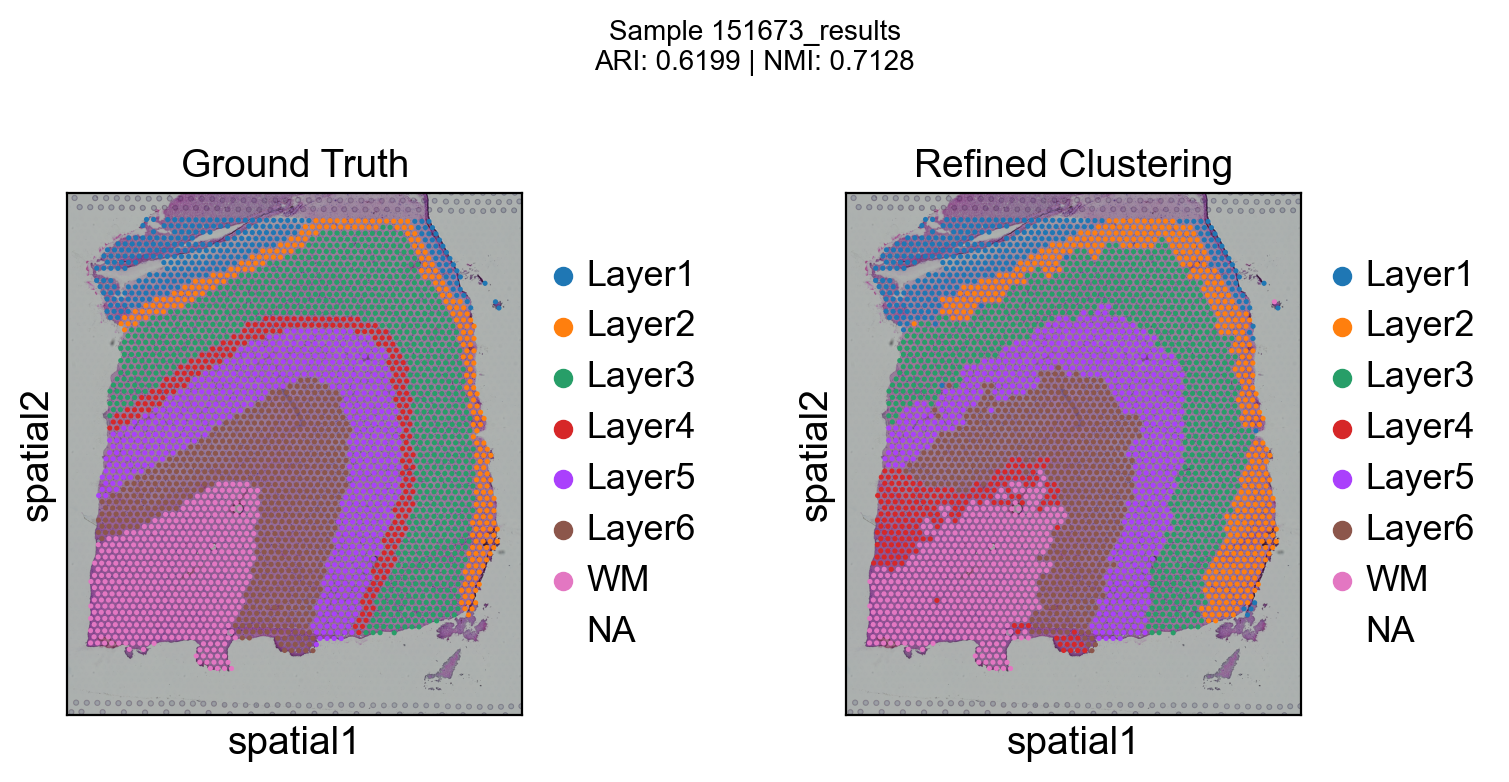

✅ Saved plot to: C:\Users\assali.i\Desktop\jspca-project\tutorial\..\results\Monoslice\jsPCA_151673_results_matched_refined_comparison.png


In [23]:
# ===============================
#  Plot Spatial Clustering Results
# ===============================


folder_path = output_folder

print("📂 Looking for matched .h5ad files in:", os.path.abspath(folder_path))

# Collect all matched files (after Hungarian alignment)
file_list = glob.glob(os.path.join(folder_path, "*_matched.h5ad"))

if not file_list:
    print("⚠️ No matched .h5ad files found. Make sure the Hungarian step has been executed.")
else:
    print(f"✅ Found {len(file_list)} matched files to plot:")
    for f in file_list:
        print("  •", os.path.basename(f))

# Sort by numeric ID (for consistent plotting order)
def extract_numeric_id(path):
    filename = os.path.basename(path)
    digits = ''.join(filter(str.isdigit, filename))
    return int(digits) if digits else 0

file_list = sorted(file_list, key=extract_numeric_id)

# Visualization parameters
sc.set_figure_params(dpi=100)
plt.rcParams["figure.figsize"] = (6, 3)

# Loop over each matched file
for file_path in file_list:
    basename = os.path.basename(file_path)
    slice_id = basename.replace("jsPCA_", "").replace("_matched.h5ad", "")
    plot_title = f"Sample {slice_id}"
    file_name = basename.replace(".h5ad", "")

    print(f"\n📌 Plotting: {file_name}")

    # Load data
    adata = ad.read_h5ad(file_path)

    # Ensure the necessary annotations exist
    if 'ground_truth' not in adata.obs or 'refined_pred_Hungarian' not in adata.obs:
        print(f"⚠️ Skipping {file_name}: missing 'ground_truth' or 'refined_pred_Hungarian'.")
        continue

    # Retrieve ARI/NMI if available
    ari = adata.uns.get("ARI", None)
    nmi = adata.uns.get("NMI", None)

    # Create a figure with two side-by-side plots
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    # Title with metrics (if available)
    if ari is not None and nmi is not None:
        full_title = f"{plot_title}\nARI: {ari:.4f} | NMI: {nmi:.4f}"
    else:
        full_title = plot_title
    fig.suptitle(full_title, fontsize=10)

    # Plot 1: Ground Truth
    sc.pl.spatial(
        adata,
        color="ground_truth",
        spot_size=100,
        ax=axs[0],
        show=False,
        title="Ground Truth"
    )

    # Plot 2: Refined Clustering (after Hungarian alignment)
    sc.pl.spatial(
        adata,
        color="refined_pred_Hungarian",
        spot_size=100,
        ax=axs[1],
        show=False,
        title="Refined Clustering"
    )

    # Save and show the plot
    plot_path = os.path.join(folder_path, f"{file_name}_refined_comparison.png")
    plt.tight_layout()
    plt.savefig(plot_path, dpi=150)
    plt.show()
    plt.close()

    print(f"✅ Saved plot to: {plot_path}")